In [1]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import Choice
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

In [2]:
class LearningAgent(Agent):
    def __init__(self, unique_id, model, row, learning_model):
        super().__init__(unique_id, model)
        self.row = row
        self.learning_model = learning_model  # 'RW' or 'TD'
        self.learning_rate = 0.1 # Rate of learning
        self.extinction_rate = 1.0 # Standard for RW extinction = 1, typically <1
        self.delta = 0.0 # Standard for delta = 0. Standard logstic for delta = 1, S-curve 0 < delta < 1
        self.beta = 1.0 # Responsivity to food in TD learning
        self.affect = 0.01 # Initial value outcome RW learning
        self.value_low = 0.0  # Initial value outcome TD learning
        self.value_high = 0.0 # Initial value outcome TD learning
        self.ptype = None  # The current patch color where the agent is located
        self.food_consumed = None  # Food consumed status ('L' or 'H')
        self.p_low = 0.2  # True reward value of food type L
        self.p_high = 0.8  # True reward value of food type H
        self.lambda_val = 0.8  # Max reward for RW model

    def move(self): # Move agent to the right in grid space
        x, y = self.pos
        new_x = (x + 1) % self.model.grid.width
        self.model.grid.move_agent(self, (new_x, y))       

    def eat_td(self): #Eat procedure for TDW copied from the Hammond et al. 2012 NetLogo model
        #Get current patch type
        self.ptype = self.model.grid.get_cell_list_contents([self.pos])[0].type

        # Determine food consumed based on patch type
        if self.ptype in ["HH", "LL"]:
            self.food_consumed = self.ptype[0]
        elif self.value_low == self.value_high:
            self.food_consumed = random.choice(["H", "L"])
        else:
            if self.value_low > self.value_high:
                self.food_consumed = "L"
            else:
                self.food_consumed = "H"
            if random.random() < 0.05:
                self.food_consumed = "L" if self.food_consumed == "H" else "H"

    def eat_rw(self): #Eat procedure for RW adapted based on TDL decision rule 
        self.ptype = self.model.grid.get_cell_list_contents([self.pos])[0].type

        # Determine food consumed based on patch type
        if self.ptype in ["HH", "LL"]:
            self.food_consumed = self.ptype[0]
        elif self.affect == 0.5:
            self.food_consumed = random.choice(["H", "L"])
        else:
            if self.affect > 0.5: 
                self.food_consumed = "H"
            else:
                self.food_consumed = "L"
            if random.random() < 0.05:
                self.food_consumed = "L" if self.food_consumed == "H" else "H"

    def update_affect_rw(self):
        if self.food_consumed == 'H':
            self.affect += self.affect + (self.learning_rate * (self.affect ** self.delta) * (self.lambda_val - self.affect))
        else:
            self.affect += self.affect + (self.learning_rate * (self.affect ** self.delta) * self.extinction_rate * (0 - self.affect))

    def update_reward_td(self):
        if self.food_consumed == 'L':
            self.value_low += (self.value_low + self.learning_rate * (self.beta * self.p_low - self.value_low))
        else:
            self.value_high += (self.value_high + self.learning_rate * (self.beta * self.p_high - self.value_high))


    def step(self): 
        self.move()
        
        #print(f"I ate {str(self.food_consumed)}")
        #print(f"My TD reward learning is: {str(self.value_high)}")
        #print(f"My RW reward learning is: {str(self.affect)}")

        #Update learning
        if self.learning_model == 'RW':
            self.update_affect_rw()
            self.eat_rw()
        elif self.learning_model == 'TD':
            self.update_reward_td()
            self.eat_td()

class Patch(Agent):
    def __init__(self, unique_id, model, patch_type):
        super().__init__(unique_id, model)
        self.type = patch_type

    def get_color(self):
        if self.type == "HH":
            return "red"
        elif self.type == "LL":
            return "blue"
        elif self.type == "HL":
            return "purple"
        return "white"
    
class LearningModel(Model):
    def __init__(self, N, width, height, learning_model='RW', distribute_patches = 'random'):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = SimultaneousActivation(self)
        self.learning_model = learning_model

        #Create agents 
        for i in range(self.num_agents):
            agent = LearningAgent(i, self, row=i, learning_model=learning_model)
            self.grid.place_agent(agent, (0, i))
            self.schedule.add(agent)

        #Add patches with types based on different distributions
        if distribute_patches == 'random':
            self.distribute_randomly()
        elif distribute_patches == 'gradient_h':
            self.distribute_gradient_h()
        elif distribute_patches == 'gradient_l':
            self.distribute_gradient_l()

        self.datacollector = DataCollector(
            agent_reporters={"Affect": "affect", "Value_Low": "value_low", "Value_High": "value_high"}
        )

    def distribute_randomly(self):
        patch_types = ["HH", "LL", "HL"]
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                patch_type = random.choice(patch_types)
                patch = Patch(f'patch_{x}_{y}', self, patch_type)
                self.grid.place_agent(patch, (x,y))

    def distribute_gradient_h(self):
        for y in range(self.grid.height):
            for x in range(self.grid.width):
                prob_hh = x / self.grid.width
                if random.random() < prob_hh:
                    patch_type = "HL"
                else:
                    patch_type = "HH"
                patch = Patch(f'patch_{x}_{y}', self, patch_type)
                self.grid.place_agent(patch, (x, y))

    def distribute_gradient_l(self):
        for y in range(self.grid.height):
            for x in range(self.grid.width):
                prob_ll = x / self.grid.width
                if random.random() < prob_ll:
                    patch_type = "HL"
                else:
                    patch_type = "LL"
                patch = Patch(f'patch_{x}_{y}', self, patch_type)
                self.grid.place_agent(patch, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def visualize(self):
        grid_matrix = []
        for y in range(self.grid.height):
            row = []
            for x in range(self.grid.width):
                cell_content = self.grid.get_cell_list_contents([(x,y)])
                patch = next((obj for obj in cell_content if isinstance(obj, Patch)), None)
                if patch:
                    row.append(patch.get_color())
                else:
                    row.append("white")
            grid_matrix.append(row)

        fig, ax = plt.subplots(figsize=(10, 10))
        cmap = mcolors.ListedColormap(['red', 'blue', 'purple', 'white'])
        bounds = [0, 1, 2, 3, 4]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        matrix = [[bounds.index(cmap.colors.index(color)) for color in row] for row in grid_matrix]
        ax.imshow(matrix, cmap = cmap, norm = norm)

        plt.show()    

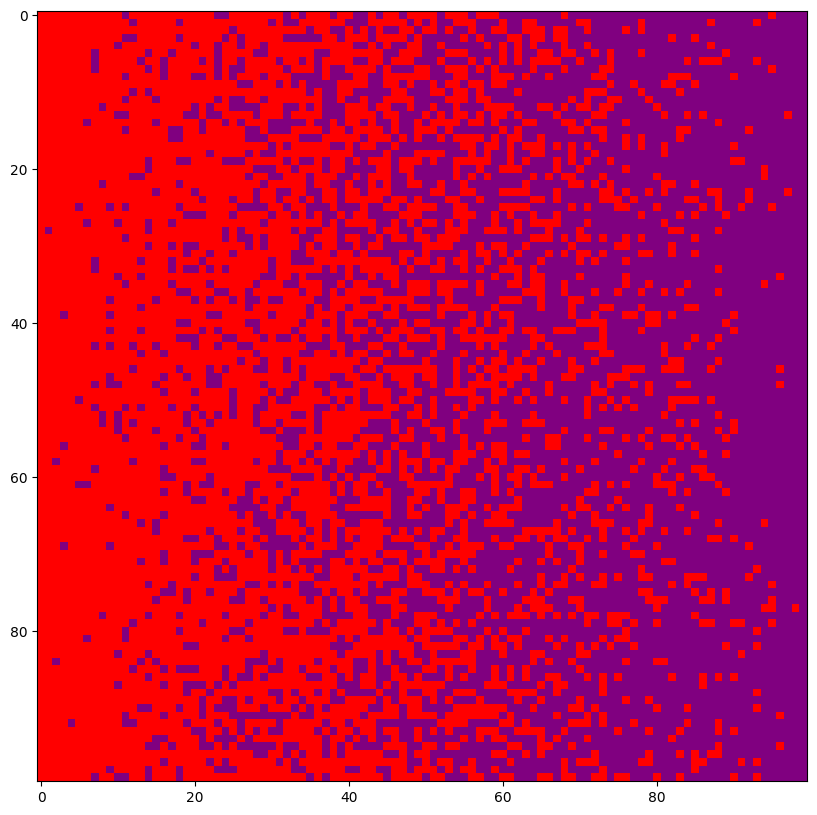

In [3]:
# Running the model
model = LearningModel(N=100, width=100, height=100, learning_model='TD', distribute_patches = 'gradient_h')

for i in range(100):
    model.step()

df1 = model.datacollector.get_agent_vars_dataframe()

model.visualize() #In case you want to check distribution of food on map.

   Step  AgentID  Affect  Value_Low  Value_High  avg_value  avg_affect
0     0        0    0.01        0.0         0.0        0.0      0.0001
1     0        1    0.01        0.0         0.0        0.0      0.0001
2     0        2    0.01        0.0         0.0        0.0      0.0001
3     0        3    0.01        0.0         0.0        0.0      0.0001
4     0        4    0.01        0.0         0.0        0.0      0.0001


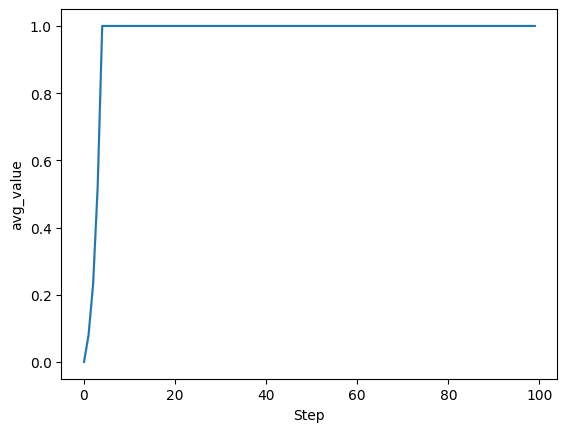

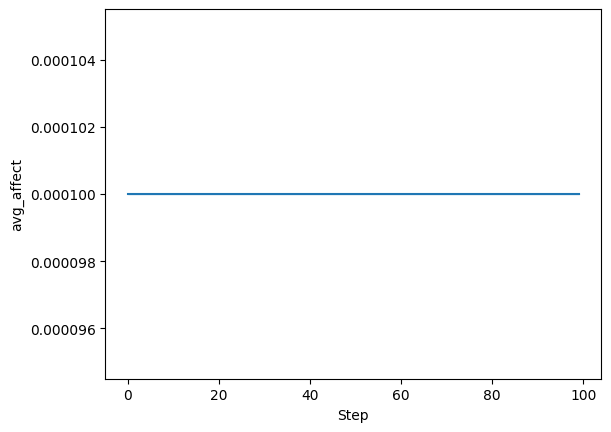

In [5]:
import seaborn as sns
import pandas as pd

df2 = df1.reset_index()
df2['avg_value'] = df2['Value_High'] / 100
df2['avg_affect'] = df2['Affect'] / 100              

print(df2.head())

td = sns.lineplot(df2, x='Step', y = 'avg_value')
plt.show(td)

rw = sns.lineplot(df2, x='Step', y = 'avg_affect')
plt.show(rw)

In [7]:
#LOCAL SERVER; BUT DOES NOT REALLY WORK

def agent_portrayal(agent):
    if isinstance(agent, Patch):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Color": agent.get_color(),
                     "Layer": 0,
                     "w": 1,
                     "h": 1}
    else:
        portrayal = {"Shape": "circle",
                     "Filled": "true",
                     "Color": "white",
                     "Layer": 1,
                     "r": 1}
    return portrayal

# Create a grid visualization
grid = CanvasGrid(agent_portrayal, 100, 100, 500, 500)

# Create a chart for agent affects
chart = ChartModule(
    [{"Label": "Affect", "Color": "Black"}, {"Label": "Value_Low", "Color": "Blue"}, {"Label": "Value_High", "Color": "Red"}]
)

model_params = {
    "N": 100,
    "width": 100,
    "height": 100,
    "learning_model": Choice("Learning Model", value="RW", choices=["RW", "TD"]),
    "distribute_patches": Choice("Patch Distribution", value="random", choices=["random", "gradient_h", "gradient_l"]),
}

server = ModularServer(LearningModel, [grid, chart], "Learning Model", model_params)
server.port = 8888
server.launch()

Interface starting at http://127.0.0.1:8888


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
